In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, Constraint, EndogVar, EndogVarConditions, EndogEquation, OptimizerType, plot_loss_df

In [2]:
latex_var_mapping = {
    # constants
    r"\gamma^i": "gammai",
    r"\gamma^h": "gammah",
    r"\rho^i": "rhoi",
    r"\rho^h": "rhoh",
    r"\sigma^a": "siga",
    r"\sigma^{a}": "siga",
    r"\mu^a": "mua",
    r"\mu^O": "muO",
    r"\zeta^i": "zetai",
    r"\zeta^h": "zetah",
    r"\alpha^a": "aa",
    r"\kappa": "kappa",

    # state variables
    r"\eta_t": "eta",

    # learnable variables (agents + endogenous variables)
    r"\xi_t^i": "xii",
    r"\xi_t^h": "xih",
    r"\mu_t^{\eta}": "mue",
    r"\sigma_t^{\eta a}": "sigea",
    r"q_t^a": "qa",
    r"w_t^{ia}": "wia",
    r"w_t^{ha}": "wha",

    # variables defined by equations
    r"\iota_t^a": "iota_a",
    r"\Phi_t^a": "phi_a",
    r"c_t^i": "ci",
    r"c_t^h": "ch",
    r"\sigma^{qa}": "sigqa",
    r"\sigma_t^{qa}": "sigqa",
    r"\sigma_t^{nia}": "signia",
    r"\sigma_t^{nha}": "signha",
    r"\sigma_t^{\xi ia}": "sigxia",
    r"\sigma_t^{\xi ha}": "sigxha",
    r"\sigma_t^{na}": "signa",
    r"\mu_t^{qa}": "muqa",
    r"\hat{r_t^{ka}}": "rka_hat", # define hat first, and replace hat first
    r"r_t^{ka}": "rka",
    r"\mu_t^{ni}": "muni",
    r"\mu_t^{nh}": "munh",
    r"\mu_t^{\xi i}": "muxi",
    r"\mu_t^{\xi h}": "muxh",
}

In [3]:
pde_model = PDEModel("problem1", {"num_epochs": 2000, "loss_log_interval": 100, "optimizer_type": OptimizerType.Adam}, latex_var_mapping)
pde_model.set_state(["eta"], {"eta": [0., 1.]})
pde_model.add_agents(["xii", "xih"], {"xii": {"positive": True}, "xih": {"positive": True}})
pde_model.add_endogs(["mue", "sigea", "qa", "wia", "wha"], {"qa": {"positive": True}})
pde_model.add_params({
    "gammai": 2.0,
    "gammah": 5.0, # gammah > gammai, try different values
    "rhoi": 0.05,
    "rhoh": 0.05,
    "siga": 0.2, #\sigma^{a}
    "mua": 0.04,
    "muO": 0.04, # same mua and muO values
    "zetai":1.00005,
    "zetah":1.00005,
    "aa":0.1,
    "kappa":10000
})
pde_model.add_equation(r"$\iota_t^a = \frac{q_t^a - 1}{\kappa}$")
pde_model.add_equation(r"$\Phi_t^a = \frac{1}{\kappa} * \log(1+\kappa * \iota_t^a)$")
pde_model.add_equation(r"$c_t^i = (\rho^i)^{\zeta^i} * (\xi_t^i)^{1-\zeta^i}$")
pde_model.add_equation(r"$c_t^h = (\rho^h)^{\zeta^h} * (\xi_t^h)^{1-\zeta^h}$")
pde_model.add_equation(r"$\sigma_t^{qa} = \frac{1}{q_t^a}  * \frac{\partial q_t^a}{\partial \eta_t}  * \sigma_t^{\eta a}  * \eta_t$")
pde_model.add_equation(r"$\sigma_t^{nia} = w_t^{ia}*(\sigma^a + \sigma_t^{qa})$")
pde_model.add_equation(r"$\sigma_t^{nha} = w_t^{ha}*(\sigma^a + \sigma_t^{qa})$")
pde_model.add_equation(r"$\sigma_t^{\xi ia}  = \frac{1}{\xi_t^i} * \frac{\partial \xi_t^i}{\partial \eta_t} * \sigma_t^{\eta a} * \eta_t$")
pde_model.add_equation(r"$\sigma_t^{\xi ha}  = \frac{1}{\xi_t^h} * \frac{\partial \xi_t^h}{\partial \eta_t} * \sigma_t^{\eta a} * \eta_t$")
pde_model.add_equation(r"$\sigma_t^{na} = \eta_t * \sigma_t^{nia} + (1-\eta_t) * \sigma_t^{nha}$")
pde_model.add_equation(r"$\mu_t^{qa} = \frac{1}{q_t^a}  * \left(\frac{\partial q_t^a}{\partial \eta_t}  * \mu_t^{\eta}  * \eta_t + \frac{1}{2}  * \frac{\partial^2 q_t^a}{\partial \eta_t^2}  * (\sigma_t^{\eta a}  * \eta_t)^2\right)$")
pde_model.add_equation(r"$r_t^{ka} = \mu_t^{qa} + \mu^a + \Phi_t^a + \sigma^a * \sigma^{qa} + \frac{\alpha^a - \iota_t^a}{q_t^a}$")
pde_model.add_equation(r"$r_t = r_t^{ka} - \gamma^h * w_t^{ha} * (\sigma^a + \sigma_t^{qa})^2 + (1-\gamma^h) * \sigma_t^{\xi ha} * (\sigma^a + \sigma_t^{qa})$")
pde_model.add_equation(r"$\mu_t^{ni} = r_t - c_t^i + w_t^{ia} * (r_t^{ka} - r_t)$")
pde_model.add_equation(r"$\mu_t^{nh} = r_t - c_t^h + w_t^{ha} * (r_t^{ka} - r_t)$")
pde_model.add_equation(r"$\mu_t^{\xi i} = \frac{1}{\xi_t^i} * \left(\frac{\partial \xi_t^i}{\partial \eta_t} * \mu_t^{\eta} * \eta_t + \frac{1}{2} * \frac{\partial^2 \xi_t^i}{\partial \eta_t^2} * (\sigma_t^{\eta a} * \eta_t)^2\right)$")
pde_model.add_equation(r"$\mu_t^{\xi h} = \frac{1}{\xi_t^h} * \left(\frac{\partial \xi_t^h}{\partial \eta_t} * \mu_t^{\eta} * \eta_t + \frac{1}{2} * \frac{\partial^2 \xi_t^h}{\partial \eta_t^2} * (\sigma_t^{\eta a} * \eta_t)^2\right)$")
pde_model.add_equation(r"$\hat{r_t^{ka}} = r_t^{ka} + \frac{\mu^O - \mu^a}{\sigma^a} * (\sigma^a + \sigma_t^{qa})$")

pde_model.add_endog_equation(r"$\mu_t^{\eta} = (1-\eta_t) * (\mu_t^{ni} - \mu_t^{nh}) +(\sigma_t^{na})^2  - \sigma_t^{nia} * \sigma_t^{na}$")
pde_model.add_endog_equation(r"$\sigma_t^{\eta a} = (1-\eta_t) * (\sigma_t^{nia} - \sigma_t^{nha})$")
pde_model.add_endog_equation(r"$\hat{r_t^{ka}} - r_t = \gamma^i * w_t^{ia} * (\sigma^a  + \sigma_t^{qa})^2 + (1-\gamma^i) * \sigma_t^{\xi ia} * (\sigma^{a}  + \sigma_t^{qa})$") 
pde_model.add_endog_equation(r"$r_t^{ka} - r_t = \gamma^h * w_t^{ha} * (\sigma^a  + \sigma_t^{qa})^2 + (1-\gamma^h) * \sigma_t^{\xi ha} * (\sigma^{a}  + \sigma_t^{qa})$") 
pde_model.add_endog_equation(r"$1 = w_t^{ia} * \eta_t + w_t^{ha} * (1-\eta_t)$")
pde_model.add_endog_equation(r"$\alpha^a - \iota_t^a = (c_t^i*\eta_t + c_t^h * (1 - \eta_t)) * q_t^a$")

pde_model.add_hjb_equation(r"$\frac{\rho^i}{1-\frac{1}{\zeta^i}} * \left( \left(\frac{c_t^i}{\xi_t^i} \right)^{1-1/\zeta^i}-1 \right) + \mu_t^{\xi i} +  \mu_t^{ni} - \frac{\gamma^i}{2} * (\sigma_t^{nia})^2  - \frac{\gamma^i}{2} * (\sigma_t^{\xi ia})^2 + (1-\gamma^i) * \sigma_t^{\xi ia} * \sigma_t^{nia}$")
pde_model.add_hjb_equation(r"$\frac{\rho^h}{1-\frac{1}{\zeta^h}} * \left( \left(\frac{c_t^h}{\xi_t^h} \right)^{1-1/\zeta^h}-1 \right) + \mu_t^{\xi h} +  \mu_t^{nh} - \frac{\gamma^h}{2} * (\sigma_t^{nha})^2  - \frac{\gamma^h}{2} * (\sigma_t^{\xi ha})^2 + (1-\gamma^h) * \sigma_t^{\xi ha} * \sigma_t^{nha}$")

print(pde_model)
if not os.path.exists("./models/1d_prob2/1d_prob.pt"):
    pde_model.train_model("./models/1d_prob2", "1d_prob.pt", True)
    pde_model.load_model(torch.load("./models/1d_prob2/1d_prob_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/1d_prob2/1d_prob_best.pt"))
    pde_model.eval_model(True)

===========================Summary of Model problem1============================
Config: {
 "batch_size": 100,
 "num_epochs": 2000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam"
}
Latex Variable Mapping:
{
 "\\gamma^i": "gammai",
 "\\gamma^h": "gammah",
 "\\rho^i": "rhoi",
 "\\rho^h": "rhoh",
 "\\sigma^a": "siga",
 "\\sigma^{a}": "siga",
 "\\mu^a": "mua",
 "\\mu^O": "muO",
 "\\zeta^i": "zetai",
 "\\zeta^h": "zetah",
 "\\alpha^a": "aa",
 "\\kappa": "kappa",
 "\\eta_t": "eta",
 "\\xi_t^i": "xii",
 "\\xi_t^h": "xih",
 "\\mu_t^{\\eta}": "mue",
 "\\sigma_t^{\\eta a}": "sigea",
 "q_t^a": "qa",
 "w_t^{ia}": "wia",
 "w_t^{ha}": "wha",
 "\\iota_t^a": "iota_a",
 "\\Phi_t^a": "phi_a",
 "c_t^i": "ci",
 "c_t^h": "ch",
 "\\sigma^{qa}": "sigqa",
 "\\sigma_t^{qa}": "sigqa",
 "\\sigma_t^{nia}": "signia",
 "\\sigma_t^{nha}": "signha",
 "\\sigma_t^{\\xi ia}": "sigxia",
 "\\sigma_t^{\\xi ha}": "sigxha",
 "\\sigma_t^{na}": "signa",
 "\\mu_t^{qa}": "muqa",
 "\\hat{r_t^{ka}}": "rka_hat",

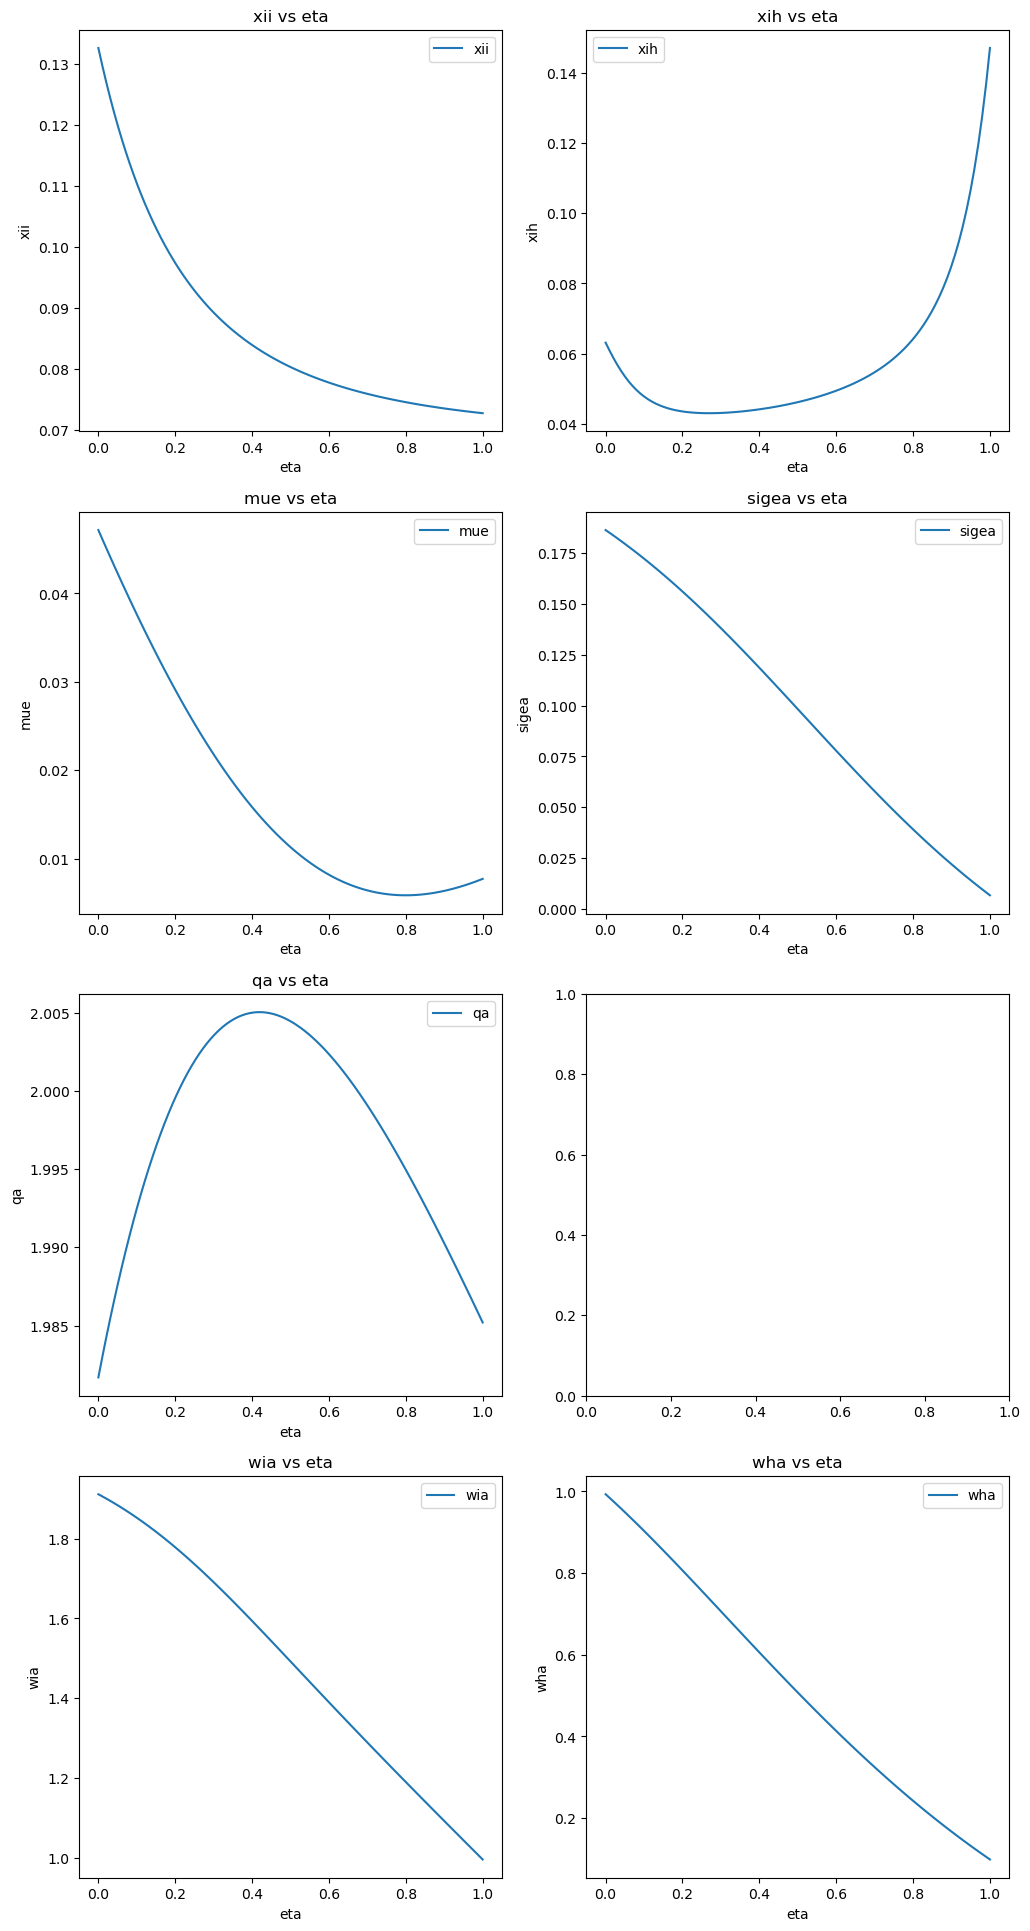

In [4]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))
pde_model.agents["xii"].plot("xii", {"eta": [0, 1]}, ax=ax[0][0])
pde_model.agents["xih"].plot("xih", {"eta": [0, 1]}, ax=ax[0][1])
pde_model.endog_vars["mue"].plot("mue", {"eta": [0, 1]}, ax=ax[1][0])
pde_model.endog_vars["sigea"].plot("sigea", {"eta": [0, 1]}, ax=ax[1][1])
pde_model.endog_vars["qa"].plot("qa", {"eta": [0, 1]}, ax=ax[2][0])
pde_model.endog_vars["wia"].plot("wia", {"eta": [0, 1]}, ax=ax[3][0])
pde_model.endog_vars["wha"].plot("wha", {"eta": [0, 1]}, ax=ax[3][1])
plt.subplots_adjust()
plt.show()

![plot1](../initial_examples/models/model1_gammah_2.5/plots/plot_train_2000_1.png)

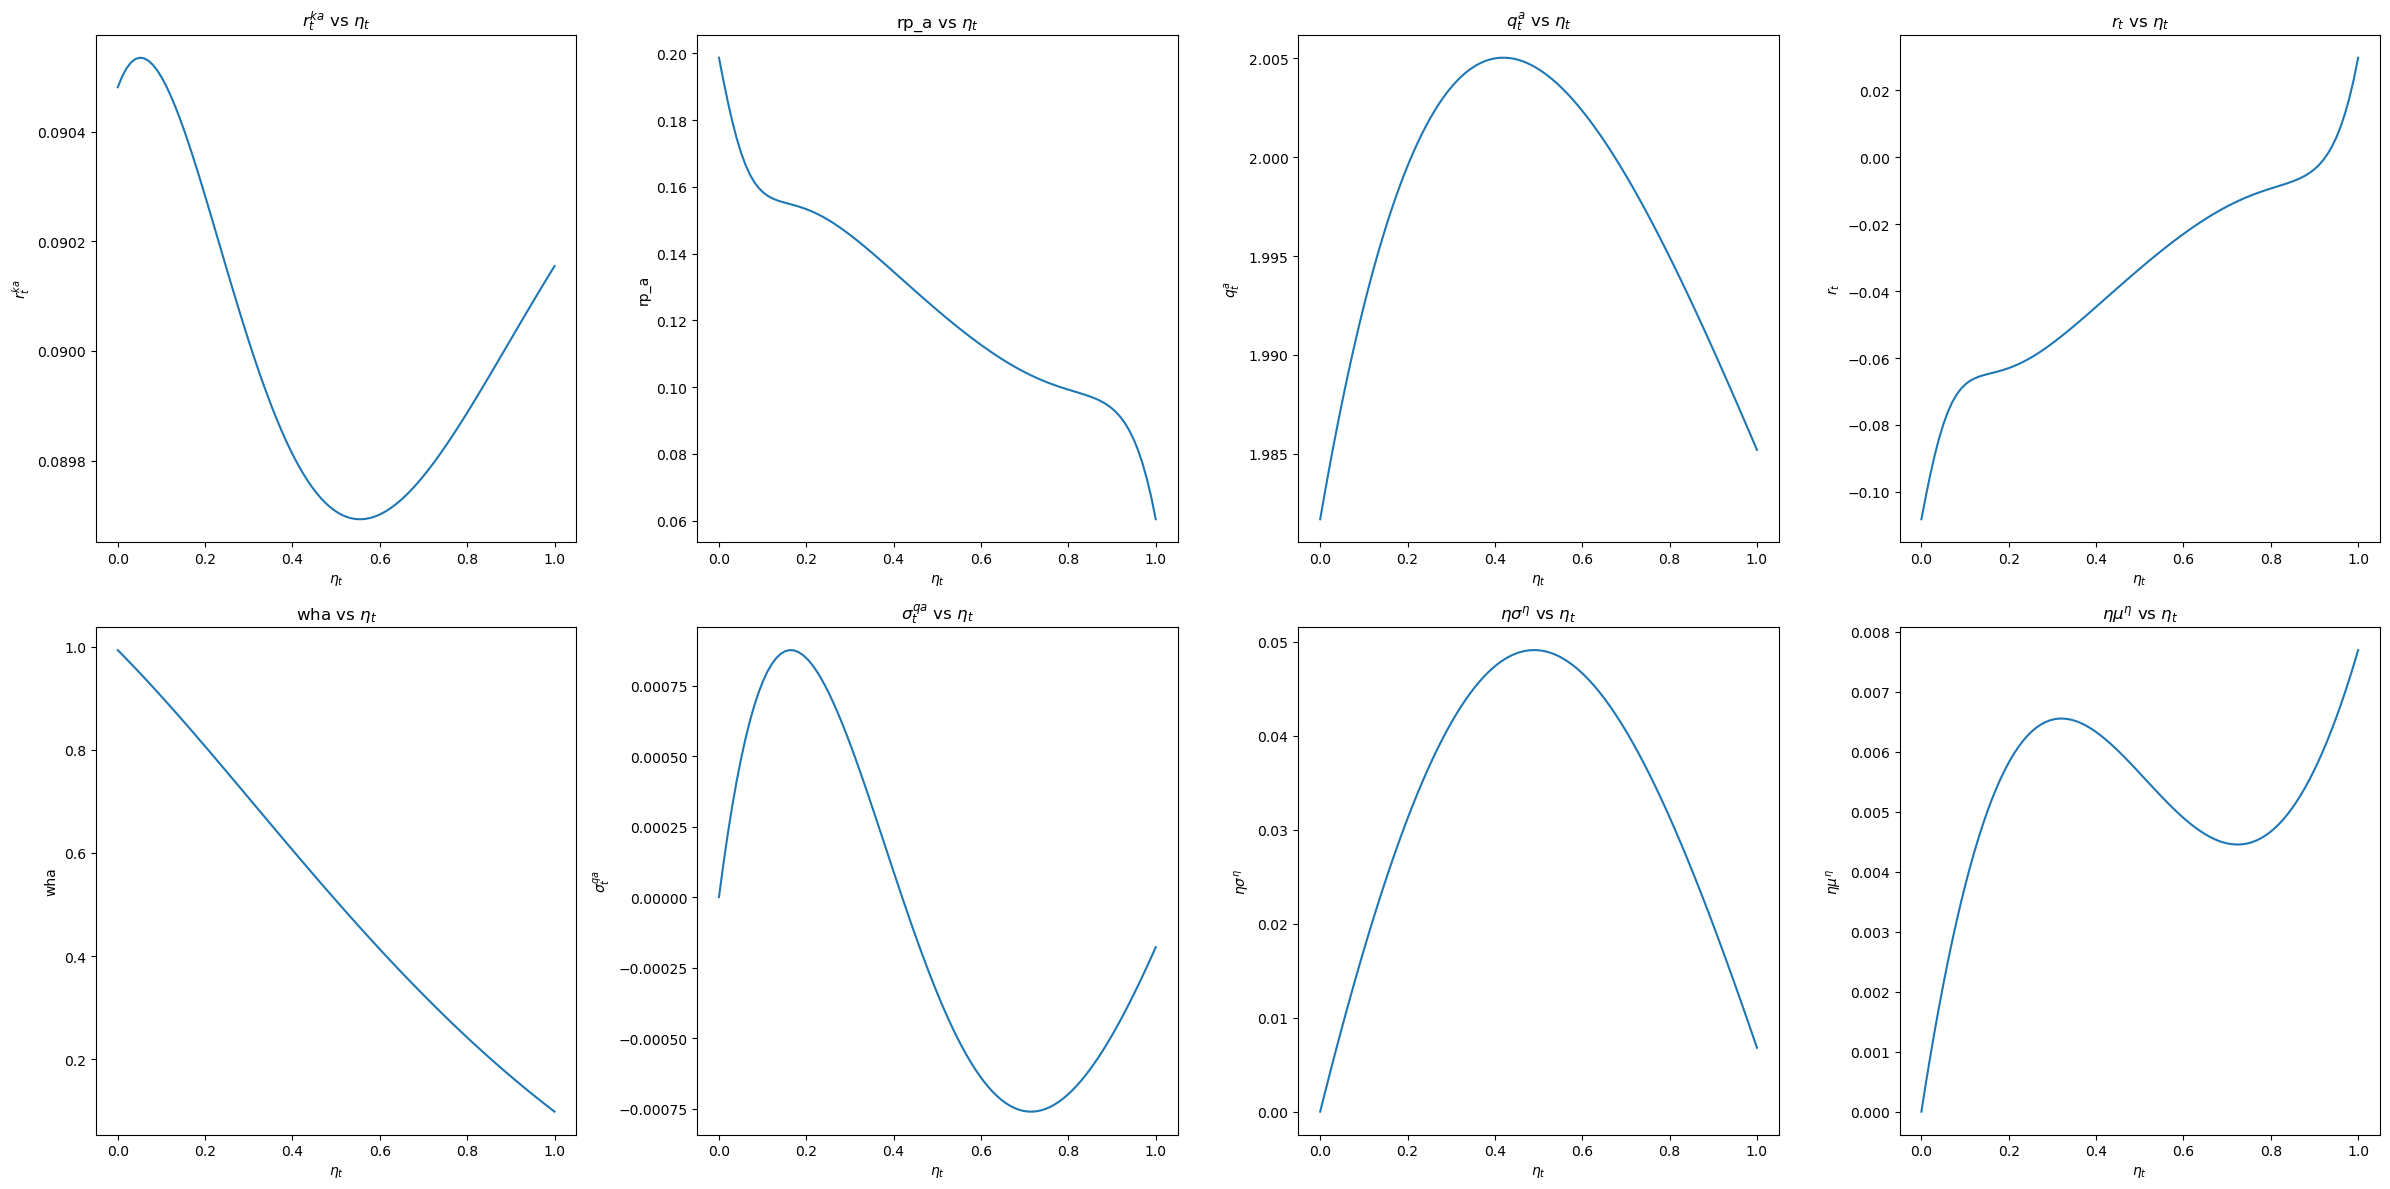

In [5]:
pde_model.plot_vars([r"$r_t^{ka}$", "rp_a=rka-r_t", r"$q_t^a$", r"$r_t$",
                     "wha", r"$\sigma_t^{qa}$", r"$\eta\sigma^{\eta}=\eta_t*\sigma_t^{\eta a}$", r"$\eta\mu^{\eta}=\eta_t*\mu_t^{\eta}$"])

![plot1](../initial_examples/models/model1_gammah_2.5/plots/plot_train_2000_2.png)

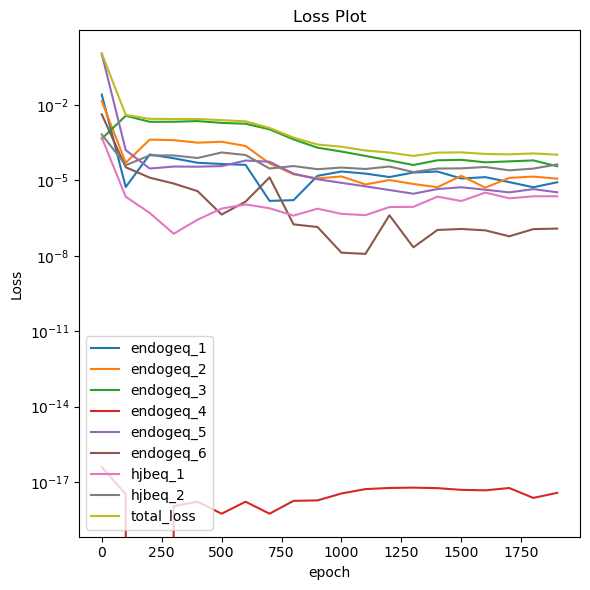

In [6]:
plot_loss_df(fn="./models/1d_prob2/1d_prob_loss.csv", loss_plot_fn="./models/1d_prob2/1d_prob1_loss.png")